In [1]:
%%time

# Dependencies to Visualize the model
%matplotlib inline
from IPython.display import display, SVG
from PIL import Image
import matplotlib.pyplot as plt

# Filepaths, numpy, pandas, and Tensorflow
import os
import numpy as np
import pandas as pd
import tensorflow as tf

# Sklearn scaling
from sklearn.preprocessing import MinMaxScaler

# Keras
from keras.models import Sequential,Model
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D
from keras.preprocessing.image import ImageDataGenerator, load_img, image
from keras.applications import VGG16

# Shutil
import shutil

CPU times: user 1.41 s, sys: 397 ms, total: 1.8 s
Wall time: 2.29 s


Using TensorFlow backend.


In [2]:
#t_directories = pd.read_csv('food-101/meta/test.txt', header=None)
#tList = t_directories[0].tolist()

#c_directories = pd.read_csv('food-101/meta/classes.txt', header=None)
#cList = c_directories[0].tolist()

#fList = [s for s in tList if any(xs in s for xs in cList)]

#with open('test.txt', 'w') as f:
#    for item in fList:
#        f.write("%s\n" % item)

In [3]:
%%time
#Only run the below code once in order to create the training directory

folderList = []

folder_directories = pd.read_csv('food-101/meta/classes.txt', header=None) #reads the classes and folders found in food-101
fList = folder_directories[0].tolist()

for item in fList:
    folderList.append(os.path.join('train/image',item)) #creates directory paths for folders needed

for item in folderList:
    os.mkdir(item)

CPU times: user 7.06 ms, sys: 3.38 ms, total: 10.4 ms
Wall time: 8.92 ms


In [4]:
%%time

#Only run the below code once in order to create the test directory

testD = []

test_directories = pd.read_csv('food-101/meta/classes.txt', header=None) #reads the classes and folders found in food-101
tfList = test_directories[0].tolist()

for item in tfList:
    testD.append(os.path.join('validation/image',item)) #creates directory paths for folders needed

for item in testD:
    os.mkdir(item)

CPU times: user 4.39 ms, sys: 2.82 ms, total: 7.21 ms
Wall time: 5.52 ms


In [5]:
%%time

currentD = []
nextD = []

t_directories = pd.read_csv('food-101/meta/train.txt', header=None)
tList = t_directories[0].tolist()

for item in tList: #only necessary to create training directory
    currentD.append(os.path.join('food-101/image',item + '.jpg'))
    nextD.append(os.path.join('train/image', item + '.jpg'))

for i in range(len(currentD)): #Only run this command once in order to create the training directory for images
    shutil.copy(currentD[i], nextD[i])

CPU times: user 1.17 s, sys: 3.25 s, total: 4.42 s
Wall time: 9.24 s


In [6]:
%%time
existingD = []
validationD = []

v_directories = pd.read_csv('food-101/meta/test.txt', header=None)
vList = v_directories[0].tolist()

for item in vList: #only necessary to create test directory
    existingD.append(os.path.join('food-101/image',item + '.jpg'))
    validationD.append(os.path.join('validation/image', item + '.jpg'))

for i in range(len(existingD)): #Only run this command once in order to create the training directory for images
    shutil.copy(existingD[i], validationD[i])

CPU times: user 412 ms, sys: 1.17 s, total: 1.58 s
Wall time: 3.45 s


In [7]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.applications import VGG16

vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
# defining directories and amount of images to train/validate
train_dir = 'train/image'
validation_dir = 'validation/image'

nTrain = 11250
nVal = 3750

In [9]:
%%time
# training images which belong to classes
datagen = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
batch_size = 20

train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,15))

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTrain:
        break
        
train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))

Found 11250 images belonging to 15 classes.
CPU times: user 8h 23min 40s, sys: 28min 28s, total: 8h 52min 9s
Wall time: 51min 1s


In [10]:
%%time

validation_features = np.zeros(shape=(nVal, 7, 7, 512))
validation_labels = np.zeros(shape=(nVal,15))

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

i = 0
for inputs_batch, labels_batch in validation_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nVal:
        break

validation_features = np.reshape(validation_features, (nVal, 7 * 7 * 512))

Found 3750 images belonging to 15 classes.
CPU times: user 2h 47min 40s, sys: 9min 24s, total: 2h 57min 4s
Wall time: 16min 56s


In [11]:
%%time
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers

model = models.Sequential()
#model.add(layers.Dense(512, activation='relu', input_dim= 7 * 7 * 512))
#model.add(layers.Dropout(0.2))
#model.add(layers.Dense(512, activation='relu'))
#model.add(layers.Dense(22, activation='softmax'))
model.add(Dense(units=512, activation='relu', input_dim=7*7*512))
model.add(layers.Dropout(0.5))
model.add(Dense(units=512, activation='relu', kernel_regularizer = regularizers.l2(0.00001)))
model.add(layers.Dropout(0.5))
model.add(Dense(units=512, activation='relu', kernel_regularizer = regularizers.l2(0.00001)))
model.add(layers.Dropout(0.5))
model.add(Dense(units=512, activation='relu', kernel_regularizer = regularizers.l2(0.00001)))
model.add(layers.Dropout(0.5))
model.add(Dense(units=512, activation='relu', kernel_regularizer = regularizers.l2(0.00001)))
model.add(layers.BatchNormalization())
model.add(Dense(units=15, activation='softmax'))

model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

CPU times: user 167 ms, sys: 4.67 ms, total: 172 ms
Wall time: 170 ms


In [12]:
%%time
history = model.fit(train_features,
                    train_labels,
                    epochs=300,
                    batch_size=batch_size,
                    validation_data=(validation_features,validation_labels))

Train on 11250 samples, validate on 3750 samples
Epoch 1/300
11250/11250 [==============================] - 98s 9ms/step - loss: 3.3107 - acc: 0.0711 - val_loss: 2.7116 - val_acc: 0.1011
Epoch 2/300
11250/11250 [==============================] - 95s 8ms/step - loss: 3.0714 - acc: 0.0802 - val_loss: 2.6808 - val_acc: 0.0843
Epoch 3/300
11250/11250 [==============================] - 95s 8ms/step - loss: 2.8731 - acc: 0.1051 - val_loss: 2.5838 - val_acc: 0.1413
Epoch 4/300
11250/11250 [==============================] - 94s 8ms/step - loss: 2.6632 - acc: 0.1633 - val_loss: 2.2973 - val_acc: 0.2157
Epoch 5/300
11250/11250 [==============================] - 95s 8ms/step - loss: 2.4065 - acc: 0.2252 - val_loss: 2.0790 - val_acc: 0.2885
Epoch 6/300
11250/11250 [==============================] - 95s 8ms/step - loss: 2.1743 - acc: 0.2849 - val_loss: 1.8286 - val_acc: 0.3795
Epoch 7/300
11250/11250 [==============================] - 96s 8ms/step - loss: 1.9747 - acc: 0.3424 - val_loss: 1.6948 - v

Epoch 118/300
11250/11250 [==============================] - 97s 9ms/step - loss: 0.0519 - acc: 0.9908 - val_loss: 1.6276 - val_acc: 0.6867
Epoch 119/300
11250/11250 [==============================] - 97s 9ms/step - loss: 0.0491 - acc: 0.9911 - val_loss: 1.6706 - val_acc: 0.6864
Epoch 120/300
11250/11250 [==============================] - 97s 9ms/step - loss: 0.0539 - acc: 0.9901 - val_loss: 1.6078 - val_acc: 0.6968
Epoch 121/300
11250/11250 [==============================] - 98s 9ms/step - loss: 0.0502 - acc: 0.9921 - val_loss: 1.5666 - val_acc: 0.6939
Epoch 122/300
11250/11250 [==============================] - 97s 9ms/step - loss: 0.0503 - acc: 0.9919 - val_loss: 1.5705 - val_acc: 0.6952
Epoch 123/300
11250/11250 [==============================] - 97s 9ms/step - loss: 0.0511 - acc: 0.9921 - val_loss: 1.6048 - val_acc: 0.6952
Epoch 124/300
11250/11250 [==============================] - 97s 9ms/step - loss: 0.0483 - acc: 0.9923 - val_loss: 1.6563 - val_acc: 0.6861
Epoch 125/300
11250/

11250/11250 [==============================] - 98s 9ms/step - loss: 0.0271 - acc: 0.9968 - val_loss: 1.7789 - val_acc: 0.7048
Epoch 235/300
11250/11250 [==============================] - 98s 9ms/step - loss: 0.0299 - acc: 0.9965 - val_loss: 1.7244 - val_acc: 0.7016
Epoch 236/300
11250/11250 [==============================] - 98s 9ms/step - loss: 0.0290 - acc: 0.9968 - val_loss: 1.7491 - val_acc: 0.6995
Epoch 237/300
11250/11250 [==============================] - 98s 9ms/step - loss: 0.0326 - acc: 0.9954 - val_loss: 1.7877 - val_acc: 0.6973
Epoch 238/300
11250/11250 [==============================] - 98s 9ms/step - loss: 0.0301 - acc: 0.9958 - val_loss: 1.7624 - val_acc: 0.6971
Epoch 239/300
11250/11250 [==============================] - 98s 9ms/step - loss: 0.0323 - acc: 0.9958 - val_loss: 1.7387 - val_acc: 0.7016
Epoch 240/300
11250/11250 [==============================] - 98s 9ms/step - loss: 0.0287 - acc: 0.9967 - val_loss: 1.7185 - val_acc: 0.7019
Epoch 241/300
11250/11250 [=======

In [13]:
model.save("food_trained.h5")

In [14]:
from keras.models import load_model
model = load_model("food_trained.h5")

In [15]:
%%time
fnames = validation_generator.filenames
 
ground_truth = validation_generator.classes
 
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
predictions = model.predict_classes(validation_features)
prob = model.predict(validation_features)
 
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

No of errors = 3489/3750
CPU times: user 23.2 s, sys: 489 ms, total: 23.7 s
Wall time: 2.79 s


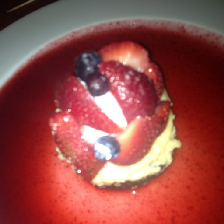

In [57]:
from keras.preprocessing import image
image_size = (224, 224)
im = image.load_img(validationD[200], target_size=image_size)
im

In [53]:
from keras.preprocessing.image import img_to_array
image = img_to_array(im)
image.shape

(224, 224, 3)

In [54]:
# Scale the image pixels by 255 (or use a scaler from sklearn here)
image /= 255

# Flatten into a 1x28*28 array 
image_resized = image.flatten().reshape(-1, 7*7*512)

image_resized.shape

(6, 25088)

In [55]:
model.predict_classes(image_resized)
#image_resized)

array([13, 13, 13, 13, 13, 13])

In [59]:
model.predict_proba(image_resized)

array([[0.02411718, 0.00829612, 0.00137448, 0.00160761, 0.07337563,
        0.20507663, 0.00309573, 0.02579488, 0.01690219, 0.01639209,
        0.01872502, 0.01469481, 0.01239592, 0.35431203, 0.22383967],
       [0.02393045, 0.00825087, 0.00137902, 0.00158174, 0.07353544,
        0.19342762, 0.00308769, 0.02548764, 0.01715609, 0.01637278,
        0.01869314, 0.014627  , 0.01255191, 0.3601184 , 0.22980022],
       [0.02325307, 0.00807026, 0.00137711, 0.00151857, 0.07323246,
        0.16823925, 0.00305723, 0.02489627, 0.01738038, 0.01604646,
        0.01826157, 0.0144565 , 0.01291451, 0.36687657, 0.25041988],
       [0.02414208, 0.00820545, 0.00138554, 0.00159218, 0.07461456,
        0.1894089 , 0.00307244, 0.02545534, 0.01743092, 0.01656013,
        0.01868246, 0.01455285, 0.01265965, 0.36530095, 0.22693655],
       [0.02358828, 0.00799719, 0.00138592, 0.00153302, 0.0744063 ,
        0.16291441, 0.00302918, 0.02485992, 0.01782057, 0.01634022,
        0.01827293, 0.01429438, 0.01299423, 

In [48]:
idx2label

{0: 'cheesecake',
 1: 'chicken_wings',
 2: 'cup_cakes',
 3: 'donuts',
 4: 'french_fries',
 5: 'grilled_cheese_sandwich',
 6: 'guacamole',
 7: 'hamburger',
 8: 'hot_and_sour_soup',
 9: 'ice_cream',
 10: 'lasagna',
 11: 'pizza',
 12: 'spaghetti_carbonara',
 13: 'sushi',
 14: 'tacos'}

In [49]:
model_loss, model_accuracy = model.evaluate(
    validation_features, validation_labels, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

Normal Neural Network - Loss: 1.8003923923333487, Accuracy: 0.6999999999682108


In [50]:
import matplotlib.pyplot as plt

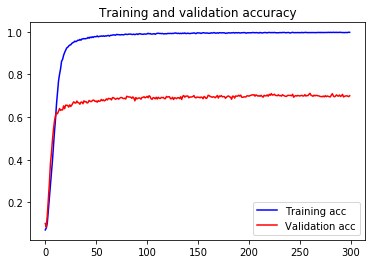

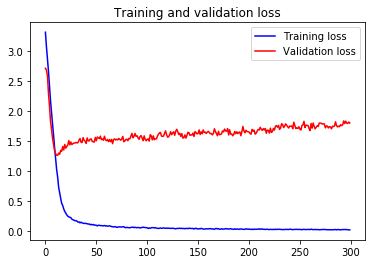

In [51]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()